In [1]:
!pip install lpips

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.8/53.8 kB 2.2 MB/s eta 0:00:00


In [2]:

# %% Import and stuff
import torch
from torch import nn
import torchvision
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torch.autograd import Variable
import numpy as np
import time
import random
import torchvision.utils as vutils
from  torch.utils import data
from mpl_toolkits.axes_grid1 import ImageGrid
import math
from collections import OrderedDict
import lpips
from torch.utils.data import Subset
from datetime import datetime 
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision import transforms
import torchvision.transforms as tran
from scipy import linalg





NUM_EPOCHS = 10
LR = 0.0002
LATENT_DIM = 100
IMG_SIZE = 28
CHANNELS = 1
B1 = 0.5
B2 = 0.999


GEN_STATE_DICT = "gen_state_dict"
DISC_STATE_DICT = "disc_state_dict"
GEN_OPTIMIZER = "gen_optimizer"
DISC_OPTIMIZER = "disc_optimizer"
G_LOSSES = "g_losses"
D_LOSSES = "d_losses"



SHUFFLE = True
PIN_MEMORY = True
NUM_WORKERS = 0
BATCH_SIZE = 2000

specific_latent = torch.tensor([[0.7628, 0.1779, 0.3978, 0.3606, 0.6387,
         0.3044, 0.8340, 0.3884, 0.9313, 0.5635, 0.1994, 0.6934, 0.5326,
         0.3676, 0.5342, 0.9480, 0.4120, 0.5845, 0.4035, 0.5298, 0.0177,
         0.5605, 0.6453, 0.9576, 0.7153, 0.1923, 0.8122, 0.0937, 0.5744,
         0.5951, 0.8890, 0.4838, 0.5707, 0.6760, 0.3738, 0.2796, 0.1549,

         0.8220, 0.2800, 0.4051, 0.2553, 0.1831, 0.0046, 0.9021, 0.0264,
         0.2327, 0.8261, 0.0534, 0.1582, 0.4087, 0.9047, 0.1409, 0.6864,
         0.1439, 0.3432, 0.1072, 0.5907, 0.6756, 0.6942, 0.6814, 0.3368,
         0.4138, 0.8030, 0.7024, 0.3309, 0.7288, 0.2193, 0.1954, 0.9948,
         0.1201, 0.9483, 0.7407, 0.4849, 0.6500, 0.8649, 0.7405, 0.4725,
         0.5373, 0.6541, 0.5444, 0.7425, 0.8940, 0.3580, 0.3905, 0.8924,
         0.2995, 0.3726, 0.5399, 0.3057, 0.3380, 0.8313, 0.1137, 0.0120,
         0.7714, 0.2561, 0.2569, 0.2994, 0.7648, 0.2413, 0.6101
        ]])


img_shape = (CHANNELS, IMG_SIZE, IMG_SIZE)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Device:{}'.format(device))


Device:cpu


In [3]:
# %% helper funcitons


def save_checkpoint(state, filename):
    print("=> Saving chekpoint")
    torch.save(state, filename)


def load_checkpoint(checkpoint):
    generator.load_state_dict(checkpoint[GEN_STATE_DICT])
    optimizer_G.load_state_dict(checkpoint[GEN_OPTIMIZER])
    discriminator.load_state_dict(checkpoint[DISC_STATE_DICT])
    optimizer_D.load_state_dict(checkpoint[DISC_OPTIMIZER])
    G_losses = checkpoint[G_LOSSES]
    D_losses = checkpoint[D_LOSSES]
    


# takes input tensor and return a tensor of same size but every element has different value
def build_fake_labels(old_list):
  
    new_list = []
    for i, x in enumerate(old_list):

        if (i % 10) != x:
            new_list.append(i % 10)
        else:
            new_list.append((x.item()+1) % 10)

    return torch.tensor(new_list, dtype=torch.int64).to(device)


def add_noise(inputs, variance):
    noise = torch.randn_like(inputs)
    return inputs + variance*noise

def gen_image(caption=-1,randomLatent=True):
    generator.to('cpu')
    discriminator.to('cpu')

    with torch.no_grad():
        for image,_ in train_loader:
            f, axarr = plt.subplots(1)
            
            if randomLatent:
                latent = torch.rand_like(torch.Tensor(1,100))
            else:
                latent = specific_latent
                
            if caption == -1:
                caption = random.randint(0, 9)
            
            caption = torch.tensor(caption, dtype=torch.int64)
            fake_image = generator(latent,caption)  
           
            
            #axarr.imshow(add_noise(image[0][0],0.5))    
            axarr.imshow(fake_image[0][0])   
            print("Supposed to be %d" %caption.item())
    
            break
        
def discriminate_image(caption=-1,genOrReal=0):#random.randint(0, 1)):
    generator.to('cpu')
    discriminator.to('cpu')
    
    with torch.no_grad():
        for  i, (imgs, labels) in enumerate(example_loader):
            f, axarr = plt.subplots(1)
            
            fake_labels = build_fake_labels(labels.to(device))
            labels = labels.to('cpu')
            z = Variable(Tensor(np.random.normal(0, 1, (1,LATENT_DIM)))).cpu()
            if caption == -1:
                caption = random.randint(0, 9)
            caption = torch.tensor(caption, dtype=torch.int64)
            
            
            #feed discriminator fake image, expect "0" output
            if genOrReal == 0:
                fake_image = generator(z,caption)
                axarr.imshow(fake_image[0].reshape(-1, 28, 28)[0])
                pred = discriminator(fake_image,caption).detach()
                print("Discriminator Prediction: {},Should be: {}, label = {}".format(pred,"0",caption))
            #feed discriminator real image, expect "1" output
            else:
                fake_image = generator(z,labels[0])
                axarr.imshow(imgs[0].reshape(-1, 28, 28)[0])
                pred = discriminator(imgs.detach(),labels[0].detach()).detach()
                print("Discriminator Prediction: {},Should be: {}, label= {}".format(pred,"1",labels[0]+1))
            
    
            break
def is_normalized(image):
  
  tensor_image_normalized = image[0]  # your tensor image here

  min_value = tensor_image_normalized.min().item()
  max_value = tensor_image_normalized.max().item()

  
  return (min_value >= -1.0 and max_value <= 1.0)

In [4]:
# %%train data

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
    ])


train_dataset = torchvision.datasets.MNIST(
    root="~/torch_datasets", train=True, transform=transform, download=True
)



train_loader = data.DataLoader(
                                train_dataset,
                                batch_size=BATCH_SIZE,
                                shuffle=False,
                                num_workers=NUM_WORKERS,
                                pin_memory=False,
                                drop_last=True
                                )

test_loader = data.DataLoader(
                                train_dataset,
                                batch_size=60000,
                                shuffle=False,
                                num_workers=NUM_WORKERS,
                                pin_memory=False
                                )

example_loader = data.DataLoader(
                                train_dataset,
                                batch_size=1,
                                shuffle=True,
                                num_workers=0,
                                drop_last=True,
                                )


100%|██████████| 9912422/9912422 [00:00<00:00, 91772939.52it/s]


Extracting /root/torch_datasets/MNIST/raw/train-images-idx3-ubyte.gz to /root/torch_datasets/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 37169590.00it/s]

Extracting /root/torch_datasets/MNIST/raw/train-labels-idx1-ubyte.gz to /root/torch_datasets/MNIST/raw




100%|██████████| 1648877/1648877 [00:00<00:00, 23070889.71it/s]


Extracting /root/torch_datasets/MNIST/raw/t10k-images-idx3-ubyte.gz to /root/torch_datasets/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 22897270.15it/s]

Extracting /root/torch_datasets/MNIST/raw/t10k-labels-idx1-ubyte.gz to /root/torch_datasets/MNIST/raw



In [5]:
# %% Detective: fake or no fake -> 1 output [0, 1]
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv1 = nn.Conv2d(2, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 1)

        self.emb = nn.Embedding(10, 50)
        self.emb_fc = nn.Linear(50, 784)

        self.nconv1 = nn.Conv2d(2, 64, kernel_size=5)
        self.nconv2 = nn.Conv2d(64, 128, kernel_size=5)
        self.pool = nn.AvgPool2d(kernel_size=3)
        self.pool2 = nn.AvgPool2d(kernel_size=2)
        self.nfc1 = nn.Linear(1152, 164)
        self.nfc2 = nn.Linear(164, 1)

    def forward(self, x, c,t3 =-1):

        if  type(t3) == int:
            c = self.emb(c)
        else:
            c = t3
        c = self.emb_fc(c)
        c = c.view(-1, 1, 28, 28)
        x = torch.cat((c, x), 1)  # concat image[1,28,28] with text [1,28,28]

        x = F.leaky_relu(self.nconv1(x))
        x = F.leaky_relu(self.nconv2(x))
        x = self.pool(x)
        x = self.pool2(x)
        x = x.view(-1, 1152)
        x = F.leaky_relu(self.nfc1(x))
        x = F.dropout(x, training=self.training)
        x = self.nfc2(x)

        x = torch.sigmoid(x)
        return x

# Check if a tensor image is normalized in [-1,1]
# returns true if it s within [-1,1]
def is_normalized(image):
  
  tensor_image_normalized = image[0]  # your tensor image here

  min_value = tensor_image_normalized.min().item()
  max_value = tensor_image_normalized.max().item()

  
  return (min_value >= -1.0 and max_value <= 1.0)


def colorize(image):
  return torch.cat([image, image, image], dim=1)

In [6]:
# %% Generate Fake Data: output like real data [1, 28, 28] and values -1, 1
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin1 = nn.Linear(LATENT_DIM, 7*7*63)  # [n,100]->[n,3087]
        self.ct1 = nn.ConvTranspose2d(64, 32, 4, stride=2)  # [n, 64, 16, 16] [32,..,..]
        self.ct2 = nn.ConvTranspose2d(32, 16, 4, stride=2)  # [n, 32, , ]->[n, 16, 34, 34]
        self.conv = nn.Conv2d(16, 1, kernel_size=7)  # [n, 16, 34, 34]-> [n, 1, 28, 28]
        
        self.emb = nn.Embedding(10, 50) 
        #self.emb2 = nn.Embedding(10, 50) 

        
        self.label_lin = nn.Linear(50, 49)
        self.conv_x_c = nn.ConvTranspose2d(65, 64, 4, stride=2)  # upsample [65,7,7] -> [64,14,14]
        self.tanh = nn.Tanh()

    def forward(self, x, c1, c2 = -1, w = round(random.uniform(0.0, 1), 1)):
        # Pass latent space input into linear layer and reshape
        x = self.lin1(x)  # (n,100) -> (n,3087)
        x = F.leaky_relu(x)
        x = x.view(-1, 63, 7, 7)  # (n,3087) -> (63,7,7)
        
       
        
        #Encode label
        c1 = self.emb(c1)  # (n,) -> (n,50)
        c = c1
        
       
        if type(c2) == torch.Tensor: 
            c2 = self.emb(c2)
            c1 = c1[:,:math.floor(c1.size(1) - c1.size(1)*w)]  # slice tensor depending on w
            c2 = c2[:,:math.floor(c2.size(1) - c2.size(1)*(1-w))]
            c = torch.cat((c1, c2), 1)
        
        else:
            #c = c1*w +(1-w)*c2
            pass

        #encoded caption
        t3 = c
        c = self.label_lin(c)  # (n,50) -> (n,49)
        c = c.view(-1, 1, 7, 7)  # (n,49) -> (n,1,7,7)
        x = torch.cat((c, x), 1) # concat image[63,7,7] with text [1,7,7]
        
        x = self.ct1(x)  
        x = F.leaky_relu(x)

        # Upsample to 34x34 (16 feature maps)
        x = self.ct2(x)
        x = F.leaky_relu(x)

        # Convolution to 28x28 (1 feature map)
        x = self.tanh(self.conv(x))
        return x

In [7]:
# %% Loss fucntion, optimizers
loss_func = nn.BCELoss()
#d_loss_func = nn.BCELoss()

# Initialize generator and discriminator
generator = Generator().to(device)
discriminator = Discriminator().to(device)

if torch.cuda.is_available():
    generator.cuda()
    discriminator.cuda()
    loss_func.cuda()

optimizer_G = torch.optim.Adam(generator.parameters(), lr=LR,betas=(B1 ,B2))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=LR,betas=(B1 ,B2))

Tensor = torch.cuda.FloatTensor if torch.cuda.is_available() else torch.FloatTensor   

In [ ]:
#if you're running this on colab, download corresponding chackpoint file and upload it to runtime
load_checkpoint(torch.load("cond_gan_pytorch10.pth.tar",map_location=(device)))


Supposed to be 1


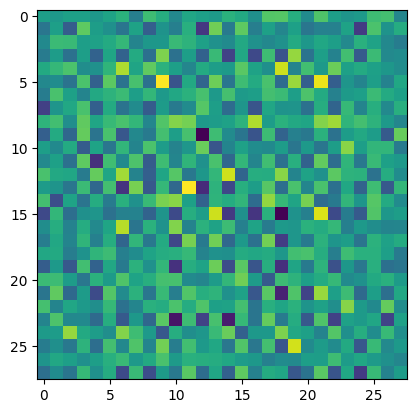

In [8]:
#Test image generation
gen_image()

In [9]:

fake_images = []
real_images = []
device='cpu'
with torch.no_grad():
    generator.to('cpu')
    discriminator.to('cpu')

    for i, (imgs,label) in enumerate(train_loader):
        real_images = imgs
        
        #caption = random.randint(0, 9)   
        #caption = torch.tensor(caption, dtype=torch.int64)
        #latent = torch.rand_like(torch.Tensor(1,100))
        #fake_images = generator(latent,caption)
        
        
        for i in range(len(real_images[:])):
          caption = label[i]
          latent = torch.rand_like(torch.Tensor(1,100))
          fake_image = generator(latent,caption)

          if (i==0):
            print('one')
            fake_images = generator(latent,caption)
          else:
            fake_images = torch.cat((fake_images, fake_image), 0)
        break
    
    #fake_images = fake_images[:BATCH_SIZE,:,:,:]
    #real_images = real_images[:BATCH_SIZE,:,:,:]

one


In [ ]:
#%% Inception score
from torchvision.models import inception_v3
from scipy.stats import entropy

with torch.no_grad():
    images = fake_images
    batch_size = BATCH_SIZE
    resize=True
    
    # Load pre-trained Inception-v3 model
    model = inception_v3(pretrained=True, transform_input=False).to(device)
    model.eval()
    model.requires_grad_ = False

    
    # Prepare the images
    transform = transforms.Compose([
        transforms.Resize((299, 299)),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
    if resize:
        images = torch.cat([images,images,images],dim=1)
        images = transforms.Compose([
            transforms.Resize((299, 299)),
            transforms.Grayscale(num_output_channels=3),
        ])(images)
    else:
        images = [torch.from_numpy(image.transpose(2, 0, 1)).float().div(255).unsqueeze(0) for image in images]
    
    # Compute the predictions
    n_images = images.shape[0]
    n_batches = int(np.ceil(n_images / batch_size))
    preds = []
    with torch.no_grad():
        for i in range(n_batches):
            start_idx = i * batch_size
            end_idx = min((i + 1) * batch_size, n_images)
            batch = images.to(device)
            #batch = torch.cat(images[start_idx:end_idx], dim=0).to(device)
            pred = model(batch.detach())
            pred = F.softmax(pred, dim=1).cpu().numpy()
            preds.append(pred)
    preds = np.concatenate(preds, axis=0)
    
    # Compute the Inception Score
    scores = []
    for i in range(preds.shape[0]):
        p_yx = preds[i]
        p_y = np.expand_dims(np.mean(p_yx, axis=0), axis=0)
        scores.append(entropy(p_yx.T, p_y.T))
    kl_divergence = np.mean(scores)
    entropy_y = entropy(np.mean(preds, axis=0))
    inception_score = np.exp(kl_divergence - entropy_y)
    print(f'Inception score: {inception_score:.2f}')

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/usr/local/lib/python3.9/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (reco

Inception score: 0.37


In [ ]:
#FID score

f_images = torch.cat([fake_images, fake_images, fake_images], dim=1)
f_images = transforms.Compose([
    transforms.Resize((299, 299)),
    transforms.Grayscale(num_output_channels=3),
])(f_images)


# load a pre-trained Inception-v3 model
inception_model = inception_v3(pretrained=True, aux_logits=True,)
inception_model.to(device)
inception_model.eval()

# compute the feature representations of the real and fake images
real_features = []
fake_features = []
for batch in train_loader:
    images, _ = batch
    images = images.to(device)
    with torch.no_grad():
        images = torch.cat([images,images,images],dim=1)
        images = transforms.Compose([
            transforms.Resize((299, 299)),
            transforms.Grayscale(num_output_channels=3),
        ])(images)

           
        features = inception_model(images).view(images.size(0), -1)
    real_features.append(features.cpu().numpy())
    break
with torch.no_grad():
    features = inception_model(f_images).view(f_images.size(0), -1)
fake_features.append(features.cpu().numpy())

# calculate the mean and covariance of the feature representations
real_features = np.concatenate(real_features, axis=0)
fake_features = np.concatenate(fake_features, axis=0)
mu1, sigma1 = np.mean(real_features, axis=0), np.cov(real_features, rowvar=False)
mu2, sigma2 = np.mean(fake_features, axis=0), np.cov(fake_features, rowvar=False)

# calculate the FID score
mu_diff = mu1 - mu2
sigma_diff_sqrt = linalg.sqrtm(sigma1 @ sigma2)
fid_score = np.real(np.trace(sigma1 + sigma2 - 2*sigma_diff_sqrt)) + np.dot(mu_diff, mu_diff)
print(f'FID score: {fid_score:.2f}')


/usr/local/lib/python3.9/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py

RuntimeError: ignored

In [ ]:
#LPIPS metric 
loss_fn_alex = lpips.LPIPS(net='alex') 

lpip_fake = colorize(fake_images)
lpip_real = colorize(real_images) # !! images must be rbg and within [-1,1]

lpip_fake = transforms.Compose([
    transforms.Resize((64, 64))])(lpip_fake)

lpip_real = transforms.Compose([
    transforms.Resize((64, 64))])(lpip_real)



d = loss_fn_alex(lpip_fake, lpip_real)
print("LPIPS? ",d[0].item())



Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: /usr/local/lib/python3.9/dist-packages/lpips/weights/v0.1/alex.pth


/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/usr/local/lib/python3.9/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, f

LPIPS?  0.19169719517230988


In [ ]:
import torch

# create a tensor
my_tensor = d

# get minimum value
min_val = torch.min(my_tensor)

# get maximum value
max_val = torch.max(my_tensor)

# get mean value
mean_val = torch.mean(my_tensor)

# print the results
print("Minimum value:", min_val.item())
print("Maximum value:", max_val.item())
print("Mean value:", mean_val.item())


Minimum value: 0.06353768706321716
Maximum value: 0.3359834551811218
Mean value: 0.15877190232276917


In [ ]:
import torch
import torch.nn as nn

# create two tensors
y_true = real_images
y_pred = fake_images

# create a criterion for calculating MSE
criterion = nn.MSELoss()

# calculate MSE
mse = criterion(y_pred, y_true)

# print the result
print("MSE:", mse.item())


MSE: 0.3394473195075989


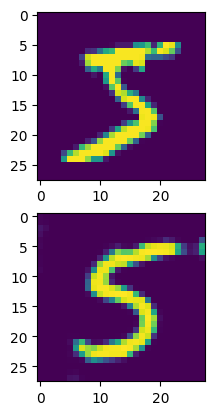

In [ ]:
ex1 = real_images[:32]
ex2 = fake_images[:32]

f, axarr = plt.subplots(2)
axarr[0].imshow(ex1[0][0])
axarr[1].imshow(ex2[0][0])   


In [ ]:
#Calculate mean of images(takes ~3 mins for max=1000)
mnist_means = []
number_mean = []
max = 100

#for each number(0,9)
for num in range(10):

  #for each image in dataset
  for k,(images,labels) in enumerate(test_loader):  
    for i in range(len(labels[:])):
    
      #if it's the number we want
      if num == labels[i].item():
        number_mean.append(images[i])
        
        if len(number_mean) >= max:
          break
  number_mean = torch.stack(number_mean,dim=0)
  number_mean = torch.mean(number_mean, dim=0)


  mnist_means.append(number_mean)
  number_mean = []
  
mnist_mean = torch.stack(mnist_means,dim=0)

KeyboardInterrupt: ignored

In [ ]:
# set seed for reproducibility
random.seed(42)

mnist_means = []
max = 100

# convert dataset to numpy array
test_array = np.array([(np.array(x), y) for x, y in test_loader.dataset])

# for each number(0,9)
for num in range(10):
  # get indices of images with the current number
  indices = np.where(test_array[:, 1] == num)[0]
  # randomly sample max number of images
  subset_indices = random.sample(indices.tolist(), max) if len(indices) > max else indices
  subset_array = test_array[subset_indices]

  # compute mean of sampled images using numpy
  number_mean = np.mean(subset_array[:, 0], axis=0)

  mnist_means.append(torch.from_numpy(number_mean))

mnist_mean = torch.stack(mnist_means, dim=0)


<ipython-input-93-958abf99daf8>:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  test_array = np.array([(np.array(x), y) for x, y in test_loader.dataset])


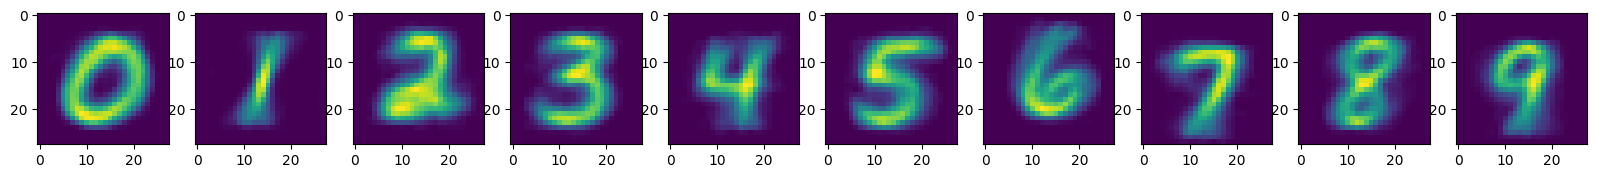

In [ ]:
fig, axes = plt.subplots(nrows=1,ncols=10,figsize=(20,2.5))
for i in range(len(mnist_mean[:])):
  axes[i].imshow(mnist_mean[i][0])

Define the distance as the minimum of the mean Euclidean distance of x
to each mean $\bar{x}k$ :
 
 $$d=\min _{0 \leq k \leq 9} \frac{1}{W H} \sqrt{\sum_i^W \sum_j^H\left(x_{i j}-\bar{x}_{k, i j}\right)^2}$$

The score is the average of $d$ over all samples.


In [ ]:
#Calculate average distances

#On how many generated images to average on
num_samples = 1000
fake_images_means = []
fake_image_mean = []

distances = []
with torch.no_grad():
  for num in range(10):
    for i in range(num_samples):
      latent = torch.rand_like(torch.Tensor(1,100))
      caption = torch.tensor(num, dtype=torch.int64)
      
      fake_image = generator(latent,caption)  
      fake_image_mean.append(fake_image[0])
    
    fake_image_mean = torch.stack(fake_image_mean,dim=0)
    fake_image_mean = torch.mean(fake_image_mean, dim=0)

    fake_images_means.append(fake_image_mean)
    fake_image_mean = []  

  

In [ ]:
fake_images_means = torch.stack(fake_images_means,dim=0)
fake_images_means.shape

torch.Size([10, 1, 28, 28])

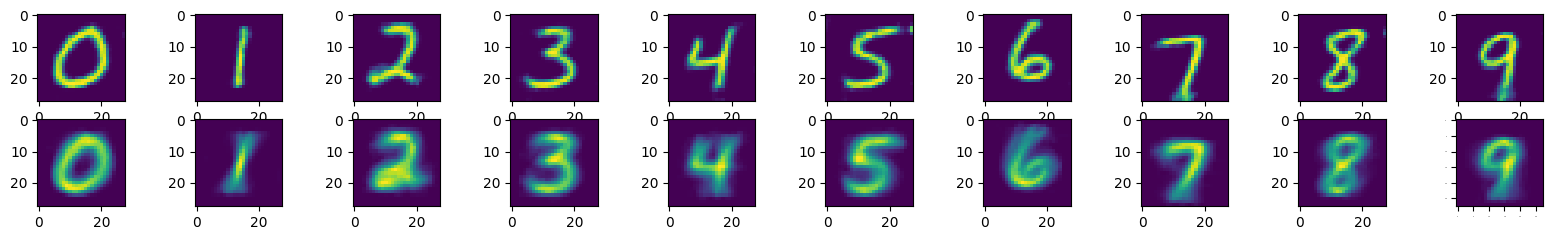

In [ ]:
fig, axes = plt.subplots(nrows=2,ncols=10,figsize=(20,2.5))
plt.tick_params(labelsize=0)


for i in range(len(mnist_mean[:])):
  axes[1][i].imshow(mnist_mean[i][0])
for i in range(len(fake_images_means[:])):
  axes[0][i].imshow(fake_images_means[i][0])



In [ ]:
#calculate distances
distances = []
for i in range(len(fake_images_means[:])):

  diff = mnist_means[i] - fake_images_means[i]
  distance = torch.norm(diff, p=2)
  #distances.append(distance.item())
  print('Number: %d, Distance: %.4f'
  %(i,distance.item()))

# Print the distance


Number: 0, Distance: 9.4604
Number: 1, Distance: 6.0773
Number: 2, Distance: 9.5981
Number: 3, Distance: 7.6404
Number: 4, Distance: 7.2333
Number: 5, Distance: 9.4148
Number: 6, Distance: 8.5297
Number: 7, Distance: 8.4616
Number: 8, Distance: 7.9925
Number: 9, Distance: 7.9970


In [10]:
class LeNet5(nn.Module):

    def __init__(self, n_classes):
        super(LeNet5, self).__init__()
        
        self.feature_extractor = nn.Sequential(            
            nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1),
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2),
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1),
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2),
            nn.Conv2d(in_channels=16, out_channels=120, kernel_size=5, stride=1),
            nn.Tanh()
        )

        self.classifier = nn.Sequential(
            nn.Linear(in_features=120, out_features=84),
            nn.Tanh(),
            nn.Linear(in_features=84, out_features=n_classes),
        )


    def forward(self, x):
        x = self.feature_extractor(x)
        x = torch.flatten(x, 1)
        logits = self.classifier(x)
        probs = F.softmax(logits, dim=1)
        return logits, probs

In [11]:
def get_accuracy(model, data_loader, device):
    '''
    Function for computing the accuracy of the predictions over the entire data_loader
    '''
    
    correct_pred = 0 
    n = 0
    
    with torch.no_grad():
        model.eval()
        for X, y_true in data_loader:

            X = X.to(device)
            y_true = y_true.to(device)

            _, y_prob = model(X)
            _, predicted_labels = torch.max(y_prob, 1)

            n += y_true.size(0)
            correct_pred += (predicted_labels == y_true).sum()

    return correct_pred.float() / n
    
def train(train_loader, model, criterion, optimizer, device):
    '''
    Function for the training step of the training loop
    '''

    model.train()
    running_loss = 0
    
    for X, y_true in train_loader:

        optimizer.zero_grad()
        
        X = X.to(device)
        y_true = y_true.to(device)
    
        # Forward pass
        y_hat, _ = model(X) 
        loss = criterion(y_hat, y_true) 
        running_loss += loss.item() * X.size(0)

        # Backward pass
        loss.backward()
        optimizer.step()
        
    epoch_loss = running_loss / len(train_loader.dataset)
    return model, optimizer, epoch_loss


def validate(valid_loader, model, criterion, device):
    '''
    Function for the validation step of the training loop
    '''
   
    model.eval()
    running_loss = 0
    
    for X, y_true in valid_loader:
    
        X = X.to(device)
        y_true = y_true.to(device)

        # Forward pass and record loss
        y_hat, _ = model(X) 
        loss = criterion(y_hat, y_true) 
        running_loss += loss.item() * X.size(0)

    epoch_loss = running_loss / len(valid_loader.dataset)
        
    return model, epoch_loss

def plot_losses(train_losses, valid_losses):
    '''
    Function for plotting training and validation losses
    '''
    
    # temporarily change the style of the plots to seaborn 
    plt.style.use('seaborn')

    train_losses = np.array(train_losses) 
    valid_losses = np.array(valid_losses)

    fig, ax = plt.subplots(figsize = (8, 4.5))

    ax.plot(train_losses, color='blue', label='Training loss') 
    ax.plot(valid_losses, color='red', label='Validation loss')
    ax.set(title="Loss over epochs", 
            xlabel='Epoch',
            ylabel='Loss') 
    ax.legend()
    fig.show()
    
    # change the plot style to default
    plt.style.use('default')

def training_loop(model, criterion, optimizer, train_loader, valid_loader, epochs, device, print_every=1):
    '''
    Function defining the entire training loop
    '''
    # set objects for storing metrics
    best_loss = 1e10
    train_losses = []
    valid_losses = []
 
    # Train model
    for epoch in range(0, epochs):

        # training
        model, optimizer, train_loss = train(train_loader, model, criterion, optimizer, device)
        train_losses.append(train_loss)

        # validation
        with torch.no_grad():
            model, valid_loss = validate(valid_loader, model, criterion, device)
            valid_losses.append(valid_loss)

        if epoch % print_every == (print_every - 1):
            
            train_acc = get_accuracy(model, train_loader, device=device)
            valid_acc = get_accuracy(model, valid_loader, device=device)
                
            print(f'{datetime.now().time().replace(microsecond=0)} --- '
                  f'Epoch: {epoch}\t'
                  f'Train loss: {train_loss:.4f}\t'
                  f'Valid loss: {valid_loss:.4f}\t'
                  f'Train accuracy: {100 * train_acc:.2f}\t'
                  f'Valid accuracy: {100 * valid_acc:.2f}')

    plot_losses(train_losses, valid_losses)
    
    return model, optimizer, (train_losses, valid_losses)    

19:34:40 --- Epoch: 0	Train loss: 1.6015	Valid loss: 0.8129	Train accuracy: 79.05	Valid accuracy: 79.87
19:35:27 --- Epoch: 1	Train loss: 0.5689	Valid loss: 0.4009	Train accuracy: 88.60	Valid accuracy: 88.81
19:36:15 --- Epoch: 2	Train loss: 0.3566	Valid loss: 0.2967	Train accuracy: 90.85	Valid accuracy: 91.56
19:37:03 --- Epoch: 3	Train loss: 0.2784	Valid loss: 0.2376	Train accuracy: 92.73	Valid accuracy: 93.19
19:37:50 --- Epoch: 4	Train loss: 0.2248	Valid loss: 0.1927	Train accuracy: 94.07	Valid accuracy: 94.39
19:38:37 --- Epoch: 5	Train loss: 0.1858	Valid loss: 0.1600	Train accuracy: 95.09	Valid accuracy: 95.36
19:39:25 --- Epoch: 6	Train loss: 0.1550	Valid loss: 0.1348	Train accuracy: 95.97	Valid accuracy: 96.10
19:40:13 --- Epoch: 7	Train loss: 0.1316	Valid loss: 0.1177	Train accuracy: 96.54	Valid accuracy: 96.53
19:41:20 --- Epoch: 8	Train loss: 0.1131	Valid loss: 0.1005	Train accuracy: 97.01	Valid accuracy: 97.11
19:42:13 --- Epoch: 9	Train loss: 0.0988	Valid loss: 0.0925	Trai

<ipython-input-11-ae618fd1f78e>:80: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


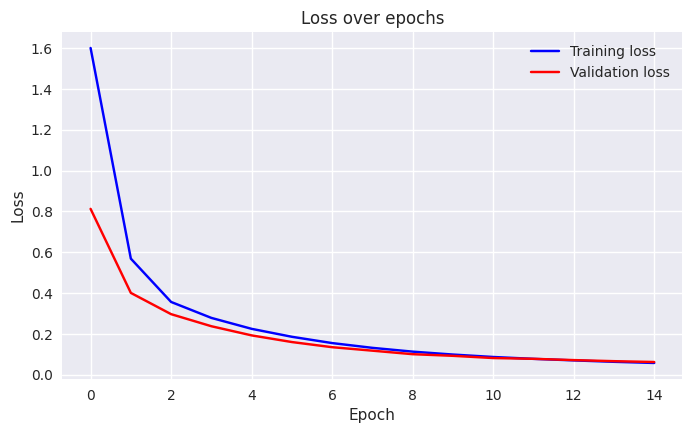

In [12]:
transforms = transforms.Compose([transforms.Resize((32, 32)),
                                 transforms.ToTensor()])

# download and create datasets
train_dataset = datasets.MNIST(root="~/torch_datasets", 
                               train=True, 
                               transform=transforms,
                               download=True)

valid_dataset = datasets.MNIST(root="~/torch_datasets", 
                               train=False, 
                               transform=transforms)

# define the data loaders
train_loader = DataLoader(dataset=train_dataset, 
                          batch_size=BATCH_SIZE, 
                          shuffle=True)

valid_loader = DataLoader(dataset=valid_dataset, 
                          batch_size=BATCH_SIZE, 
                          shuffle=False)
RANDOM_SEED = 42
LEARNING_RATE = 0.001
BATCH_SIZE = 32
N_EPOCHS = 15

IMG_SIZE = 32
N_CLASSES = 10

torch.manual_seed(RANDOM_SEED)

model = LeNet5(N_CLASSES).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss()

model, optimizer, _ = training_loop(model, criterion, optimizer, train_loader, valid_loader, N_EPOCHS, device)


In [13]:
#Save model state
leNetCheckpoint={'leNet_model_state_dict': model.state_dict(),
                 'leNet_optmizer_state_dict': optimizer.state_dict}
torch.save(leNetCheckpoint,'leNet_checkpoint.pth.tar')

In [ ]:
#Load checkpoint
leNet_load_checkpoint = torch.load('leNet_checkpoint.pth.tar')

model.load_state_dict(leNet_load_checkpoint['leNet_model_state_dict'])
optimizer.load_state_dict(leNet_load_checkpoint['leNet_optmizer_state_dict'])

In [14]:
with torch.no_grad():
  def calculate_activation_statistics(images, model):
    model.eval()
    activations = []
    
    features = model.feature_extractor(images)
    activations.append(features)
    
    activations = np.concatenate(activations, axis=0)
    mu = np.mean(activations, axis=0)

    activations = activations.reshape(activations.shape[0], -1)  # flatten the activations to 2D

    sigma = np.cov(activations, rowvar=False)
    return mu, sigma
  
  def get_features(x, model):
    model.eval()
    with torch.no_grad():
        features = model.feature_extractor(x)
        features = torch.flatten(features, 1)
    return features

  def calculate_activation_statistics(images, model):
    features = get_features(images, model).numpy()
    mu = np.mean(features, axis=0)
    cov = np.cov(features, rowvar=False)
    return mu, cov

  def calculate_frechet_distance(mu1, cov1, mu2, cov2):
    eps = 1e-6
    diff = mu1 - mu2
    # Product of two covariance matrices
    cov_mean, _ = linalg.sqrtm(cov1.dot(cov2), disp=False)
    if not np.isfinite(cov_mean).all():
        offset = np.eye(cov1.shape[0]) * eps
        cov_mean = linalg.sqrtm((cov1 + offset).dot(cov2 + offset))
    # Compute the Wasserstein-2 distance
    return np.sum(diff ** 2) + np.trace(cov1 + cov2 - 2 * cov_mean)



  # Generate fake data and compute statistics
  resize = tran.Resize((32, 32))



  fake_big = resize(fake_images)
  real_big = resize(real_images)

  mu1, cov1  = calculate_activation_statistics(fake_big, model)
  mu2, cov2 = calculate_activation_statistics(real_big, model)
  frechet_distance = calculate_frechet_distance(mu1, cov1, mu2, cov2)


  print(frechet_distance)


/usr/local/lib/python3.9/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


105.74249339253882
